### Heat equation on a time-dependent domain

With the knowledge gained from the previous examples, we can now solve the drilling problem. Here, we consider
the heat equation on a time-dependent domain $\Omega(t)$. For the PDE we consider, for $t\in(0, 5)$,
\begin{align*}
    \partial_t u(x, t) -0.1\Delta u(x, t) &= 0, && \text{ in }  \Omega(t), \\
    u(x, 0) &= 0 , && \text{ in }  \Omega(0), \\
    u(x, t) &= 0 , &&\text{ for } x_2=0, \\
    0.1 \nabla u(x, t)\cdot n &= 0 , &&\text{ on } \Gamma_N(t), \\
    0.1\nabla u(x, t)\cdot n &= f , &&\text{ on } \Gamma_H(t).
\end{align*}

Now let $D(t)$ be the drill that we use for removing material from our original domain $\Omega(0)=(0, 1) \times (0, 1)$. Here, we consider a rectangle $D(t) = (0.2, 0.4) \times (h(t), 1.0)$, where $h(t)$ describes the depth of the drill at point $t$ and is given by
\begin{align*}
    h(t) = 1.0 - v_\text{drill} \cdot t.
\end{align*}
The speed of removing the material is given by $v_\text{drill}$.

Then our time dependent domain is given by $\Omega(t) = ((0, 1) \times (0, 1)) \setminus D(t)$.

The boundary parts are given by
\begin{align*}
    \Gamma_H(t) &=  (0.2, 0.4) \times \{h(t)\}, \\
    \Gamma_N(t) &=  \partial \Omega(0) \setminus (\{x_2=0\} \cup \Gamma_H(t)),
\end{align*}
at the bottom boundary ($x_2=0$) we have a fixed temperature $u=0$, at the bottom of the drill part ($\Gamma_H$) a heat source and 
everywhere else ($\Gamma_N$) homogeneous Neumann conditions.

For visualization and to better understand the geometry, we prepared a simple depiction of the domain:

In [1]:
# Just run the cell to see the domain
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/TomF98/torchphysics/Berlin-Workshop/examples/SolutionData/DrillingData/drill_domain.png")

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

In [3]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import math 

# Here all parameters are defined:
t_min, t_max = 0.0, 5.0
t_prod_end = 5.0
prod_speed = 1.0 # speed of heating 

size_x, size_y = 1.0, 1.0
x_start, x_end = 0.2, 0.4 # x-size of drill hole
y_end = 0.4 # end height of drill hole

drill_speed = (size_y - y_end) / (t_prod_end)

kappa = 0.1 # heat diffusion

# Function for heat source
def f(t, x):
    heat_source = 80 * (x[:, :1] - x_start) * (x_end - x[:, :1])
    heat_source *= (1.0 - torch.exp(-prod_speed*t))
    return heat_source

# Movement of drill (returns the x_2 position of the bottom of the drill head)
def drill_depth(t):
    height = size_y - drill_speed * t
    return height

In [4]:
# First we have to implement the spaces that appear:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

Now, we handle the time dependent domain. The basic domain creation is like we have seen before.
Special here is now, that we use Python-functions to describe the corners of our drill hole.

To create our domain, we define first the square $(0, 1) \times (0, 1)$ and then subtract the drill hole (a 
time dependent square) from it.

In [5]:
# TODO: Implement the unit square 
box = tp.domains.Parallelogram(X, [0.0, 0.0], [size_x, 0.0], [0.0, size_y])

# This is the lower left corner of our drill hole. At a given input t, we have to return 
# the correct coordinate of the left lower corner.
def left_corner(t):
    # First construct a tensor, where we can input the correct coordinates.
    # The x-coordinate is 
    coordinate = x_start * torch.ones((len(t), 2), device=t.device)
    coordinate[:, 1:] = drill_depth(t)
    return coordinate

# TODO: Implement the lower right corner:
def right_corner(t):
    coordinate = x_end * torch.ones((len(t), 2), device=t.device)
    coordinate[:, 1:] = drill_depth(t)
    return coordinate

# Now we can use the above functions as input arguments in the Parallelogram.
# The top left corner is fixed outside the unit square (for numerical reasons), such that we obtain  
# a rectangle that grows in the negative x_2 direction over time.
drill_hole = tp.domains.Parallelogram(X, left_corner, right_corner, [x_start, size_y+0.1])

# TODO: Construct the difference of the "box" and "drill_hole"
omega = (box - drill_hole)

# TODO: Implement the time interval
I_t = tp.domains.Interval(T, t_min, t_max)

The defined domain $\Omega$ is now dependent on time, since the *drill_hole* depends on time.
This we have to keep in mind when we want to create points inside this domain. To sample points,
we have to say what time point $t$ we are considering.

This order is also important for the *Samplers* in TorchPhysics. If we input the "Cartesian" Product *omega \* I_t*, the sampler will create points from right to left, first points in the time interval and then pass them to the space domain to create valid points. 

The combination *I_t \* omega* does **not** work. 

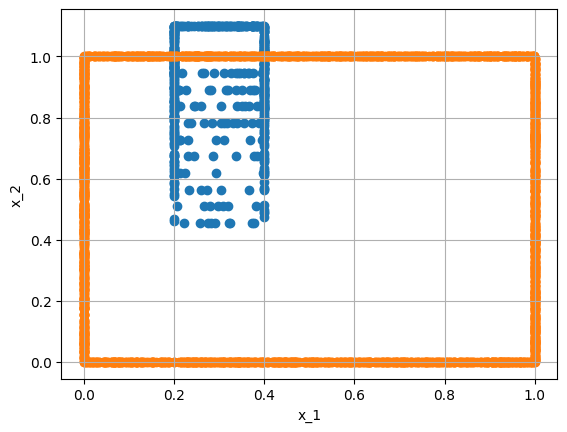

In [6]:
# TODO: Experiment a bit with different Samplers and number of points to get a feeling of the
#       time dependent domain.

inner_sampler = tp.samplers.RandomUniformSampler(omega * I_t, 5000)
bc_sampler = tp.samplers.RandomUniformSampler(box.boundary*I_t, 2000)

# One can also multiply (create the Cartesian product) of the samplers, which allows for 
# grid sampling. 
time_sampler = tp.samplers.GridSampler(I_t, 10)
drill_sampler = tp.samplers.RandomUniformSampler(drill_hole.boundary, 50) * time_sampler

# With scatter we can visualize one example batch of points.
# First argument: The space over which we want to plot (here either: X, T or X*T)
# Later arguments all sampler we want to visualize.
# Note: The points in the plot not always have the correct three-dimensional "depth", 
# they may incorrectly appear behind or in front of each other.
fig = tp.utils.scatter(X, drill_sampler, bc_sampler)

For training we use the following sampler:

In [7]:
# When making a sampler static (e.g. fixing the points it creates) we can also pass specify
# after how many training iterations new points will be created.
# We do this here to speed up the training process, since sampling in time dependent domains
# is a little bit slower than in normal domains. 
inner_sampler = tp.samplers.RandomUniformSampler(omega * I_t, 75000).make_static(resample_interval=250)
def bc_filter(x):
    return (x[:, 1] > 0.0001) & ((x[:, 0] < x_start) | (x[:, 0] > x_end))
bc_sampler = tp.samplers.RandomUniformSampler(box.boundary*I_t, 25000, filter_fn=bc_filter)

time_sampler = tp.samplers.GridSampler(I_t, 120).make_static()
drill_sampler = tp.samplers.RandomUniformSampler(drill_hole.boundary, 2000) * time_sampler

In [8]:
# Next the neural network:
model = tp.models.FCN(input_space=X*T, output_space=U, 
                      hidden=(80, 80, 80, 80, 80, 80, 80))

To simplify the training procedure, we implement some conditions into the network architecture by using the so called *hard constrains*.
These include the initial condition $u(\cdot, 0) = 0$ and the Dirichlet condition at the lower boundary. 
A simple way to achieve this, is to multiply the output of the neural network by some factors such that the conditions are fulfilled.

In our case this is possible with
\begin{align*}
    u \cdot (1.0 - e^{-t}) \cdot x_2,
\end{align*}
where $u$ is the output of the neural network.

In [9]:
# TODO: Implement the hard constrains
def constrain_fn(u, x, t):
    return u * (1.0-torch.exp(-t)) * x[:, 1:]

Next, we implement the PDE via the *PINNCondition* as we did before.

In [10]:
# Start we the heat equation
def pde_residual(u, x, t):
    u = constrain_fn(u, x, t) # here remember to apply our constrain 
    return kappa * tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition', weight=50)

In [11]:
# Next the boundary conditions at the drill hole:
tol = 0.0001 # small tolerance for filtering points

def drill_residual(u, x, t):
    u = constrain_fn(u, x, t)

    residual = torch.zeros_like(u) # a tensor to write the residual into
    normal_vectors = -drill_hole.boundary.normal(x, {"t": t})
    u_n = tp.utils.normal_derivative(u, normal_vectors, x)
    
    # Evaluate heat source everywhere (filter out correct points later)
    heat_source = f(t, x) 
    # The upper boundary of our drill hole rectangle is not inside the domain
    # -> filter out the correct points
    point_in_domain = (x[:, 1:] <= size_y)

    # Then construct residual:
    residual[point_in_domain] = (u_n - heat_source/kappa)[point_in_domain]

    return residual

drill_condition = tp.conditions.PINNCondition(module=model,
                                           sampler=drill_sampler,
                                           residual_fn=drill_residual,
                                           name='drill_condition', weight=2)

In [12]:
# TODO: Implement the condition for the outer boundary (not on the drill hole)

def bc_residual(u, x, t):
    # Apply constrains:
    u = constrain_fn(u, x, t)
    
    # Compute normal vectors and derivative:
    normals = box.boundary.normal(x)
    u_n = tp.utils.normal_derivative(u, normals, x)

    # Construct residual:
    return u_n

bc_condition = tp.conditions.PINNCondition(module=model,
                                           sampler=bc_sampler,
                                           residual_fn=bc_residual,
                                           name='bc_condition', weight=100)

Now, we can start the training of the neural network. 
In our testing we found that first only training the boundary condition on the drill part is helpful:

In [ ]:
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=1.e-4)
solver = tp.solver.Solver([drill_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=2500, 
                     logger=False, 
                     callbacks=[RichProgressBar(refresh_rate=20, theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                     enable_checkpointing=False
                     )

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 39.3 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/tra

Epoch 0: 100%|██████████| 2500/2500 [02:16<00:00, 18.37it/s, train/loss=0.0261]

`Trainer.fit` stopped: `max_steps=2500` reached.


Epoch 0: 100%|██████████| 2500/2500 [02:16<00:00, 18.37it/s, train/loss=0.0261]


Next, we combine all loss terms in the training process. Here, we only train for a short time frame. Since we use a rather large network and multiple participants use the available GPUs simultaneously, the training is slow. 

But we can still obtain a good first approximation and in the later cells also load a pretrained network, that we trained for roughly 25 minutes on a GTX 2080 beforehand.

In [ ]:
learning_rates = [1.e-3, 2.e-4, 1e-4, 5e-5, 2.5e-5]
iterations = [1500, 2500, 4000, 1000, 2000]
for i in range(len(learning_rates)):
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rates[i]) 
    solver = tp.solver.Solver([pde_condition, drill_condition, bc_condition],
                            optimizer_setting=optim)

    trainer = pl.Trainer(devices=1, accelerator="gpu",
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=iterations[i],
                        logger=False, 
                        callbacks=[RichProgressBar(refresh_rate=20, theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                        enable_checkpointing=False
                        )

    trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 39.3 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1500 [00:00<?, ?it/s] 

/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/cut.py:46: UserWarning: Exact volume of this cut is not known, will use the
                             estimate: volume = domain_a.volume.
                             If you need the exact volume for sampling,
                             use domain.set_volume()
  warnings.warn(


Epoch 0:  32%|███▏      | 476/1500 [01:10<02:30,  6.79it/s, train/loss=6.350]  

First we can have a look on the learned solution:

In [ ]:
anim_sampler = tp.samplers.AnimationSampler(omega, I_t, 50, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u, t, x: constrain_fn(u, x, t), 
                             anim_sampler, ani_speed=10, ani_type='contour_surface')
anim.save('moving-heat-eq.gif')
# You should be able to see a tab with a folder on the left side of your screen. There you can find the gif and can watch it.

/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/sampler_helper.py:52: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 1
                     This may slow down the training.
  warnings.warn(
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/sampler_helper.py:172: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 1
                     This may slow down the training.
  warnings.warn(
/home/t

We also prepared a FEM-solution for comparison. 

In [ ]:
import numpy as np

time_points = np.load("/localdata/komso/datasets/SolutionData/DrillingData/time_points.npy")
coords = np.load("/localdata/komso/datasets/SolutionData/DrillingData/coordinates.npy")
fem_sol = np.load("/localdata/komso/datasets/SolutionData/DrillingData/solution.npy")

In [ ]:
# Now evaluate the PINN solution at the FEM-points and compare the solution.
pinn_sol = torch.zeros((len(time_points), len(coords[0])))

for i in range(len(time_points)):
    input_points = torch.zeros((len(coords[i]), 3))
    input_points[:, :2] = torch.tensor(coords[i], dtype=torch.float32)
    input_points[:, 2] = time_points[i]
    model_out = model(tp.spaces.Points(input_points, X*T)).as_tensor
    pinn_sol[i, :] = constrain_fn(model_out, input_points[:, :2], input_points[:, 2:]).flatten()

print("Difference to FEM in Sup-norm:")
difference_sup = np.max(np.abs(fem_sol - pinn_sol.detach().numpy()))
print("Absolute:", difference_sup)
print("Relative:", difference_sup / np.max(fem_sol))

Difference to FEM in Sup-norm:
Absolute: 1.8543381806841328
Relative: 1.827316205857046


Since we only trained for a short time frame, the relative error is still large.
Therefore, we also prepared a neural network that has been trained a bit longer.

In [ ]:
# The following lines show how one can save and load a neural network
torch.save(model.state_dict(), '/localdata/komso/datasets/DrillingData/current_model.pt')

model.load_state_dict(torch.load('/localdata/komso/datasets/DrillingData/model_drilling.pt'))

<All keys matched successfully>

We evaluate the new model and obtain a relative error of around 9%.

In [ ]:
pinn_sol = torch.zeros((len(time_points), len(coords[0])))

for i in range(len(time_points)):
    input_points = torch.zeros((len(coords[i]), 3))
    input_points[:, :2] = torch.tensor(coords[i], dtype=torch.float32)
    input_points[:, 2] = time_points[i]
    model_out = model(tp.spaces.Points(input_points, X*T)).as_tensor
    pinn_sol[i, :] = constrain_fn(model_out, input_points[:, :2], input_points[:, 2:]).flatten()

In [ ]:
print("Difference to FEM in Sup-norm:")
difference_sup = np.max(np.abs(fem_sol - pinn_sol.detach().numpy()))
print("Absolute:", difference_sup)
print("Relative:", difference_sup / np.max(fem_sol))

Difference to FEM in Sup-norm:
Absolute: 0.09095481719461318
Relative: 0.08962939618660247
